In [1]:
spark

In [2]:
#Read the files in and specify the bucket and directory path
bucket_name = "my-bucket-apb"
directory_path = "cleaned4"

# Read Parquet files 
sdf = spark.read.parquet(f"gs://{bucket_name}/{directory_path}/*.parquet")

# Show the DataFrame schema and some sample data— 5 rows specifically 
sdf.printSchema()
sdf.show(5)  # Show the first 5 rows

root
 |-- book_id: integer (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- author_id: integer (nullable = true)
 |    |    |-- role: string (nullable = true)
 |-- average_rating: float (nullable = true)
 |-- description: string (nullable = true)
 |-- format: string (nullable = true)
 |-- num_pages: integer (nullable = true)
 |-- popular_shelves: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- count: integer (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- ratings_count: integer (nullable = true)
 |-- text_reviews_count: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- publication_date: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- n_votes: integer (nullable = true)
 |-- n_comments: integer (nullable = true)
 |-- date_added_formatted: st

+-------+----------+--------------+--------------------+---------+---------+--------------------+-------------+------------------+--------------------+----------------+--------------------+------+--------------------+-------+----------+--------------------+-----------------+--------------------+------------------+
|book_id|   authors|average_rating|         description|   format|num_pages|     popular_shelves|ratings_count|text_reviews_count|               title|publication_date|             user_id|rating|         review_text|n_votes|n_comments|date_added_formatted|read_at_formatted|started_at_formatted|review_text_length|
+-------+----------+--------------+--------------------+---------+---------+--------------------+-------------+------------------+--------------------+----------------+--------------------+------+--------------------+-------+----------+--------------------+-----------------+--------------------+------------------+
|     24|[{NULL, }]|          4.05|A CLASSIC FROM TH

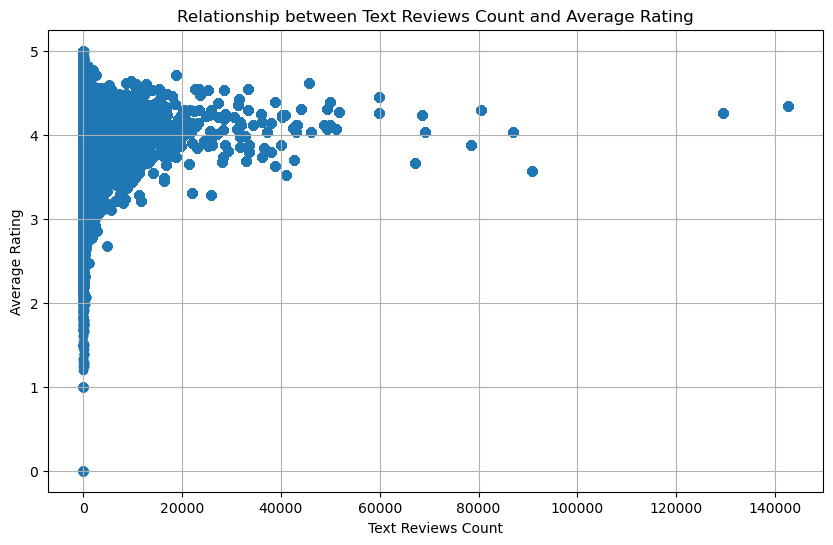

In [26]:
#Visalizations:Finding the Relationship between Text Reviews Count and Average Rating 
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

df_scatter = sdf.select("text_reviews_count", "average_rating").toPandas()

# Plotting the data
my_plot = plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['text_reviews_count'], pandas_df['average_rating'])
plt.xlabel('Text Reviews Count')
plt.ylabel('Average Rating')
plt.title('Relationship between Text Reviews Count and Average Rating')
plt.grid(True)
plt.show()


In [29]:
# Save the plot to Google Cloud Storage
import io
from google.cloud import storage

# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the img_data buffer
my_plot.get_figure().savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket on Google Cloud Storage (change this to match the name of your bucket)
bucket = storage_client.get_bucket('my-bucket-apb')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("Relationship between Text Reviews Count and Average Rating.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

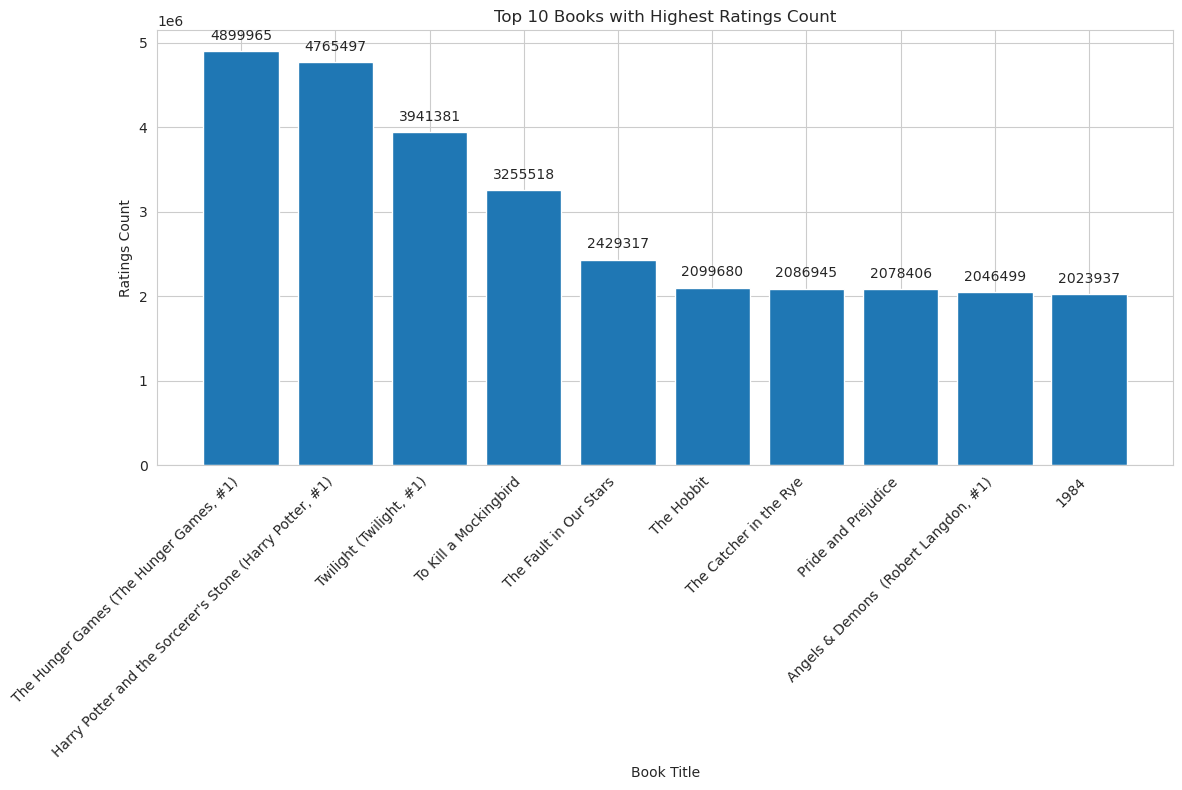

In [49]:
#Visalizations: Find the top 10 unique books with the highest ratings_count

import matplotlib.pyplot as plt
from pyspark.sql.functions import col, desc

# Find the top 10 unique books with the highest ratings_count
top_10_books = sdf.groupBy('title').agg({'ratings_count': 'max'}).orderBy(desc('max(ratings_count)')).limit(10).toPandas()

# Set up the bar plot
plt.figure(figsize=(12, 8))
bar_plot = plt.bar(top_10_books['title'], top_10_books['max(ratings_count)'])
plt.xlabel('Book Title')
plt.ylabel('Ratings Count')
plt.title('Top 10 Books with Highest Ratings Count')

# Set x-axis labels
plt.xticks(rotation=45, ha='right')

# Adding graph annotations for exact ratings_count 
for i, val in enumerate(top_10_books['max(ratings_count)']):
    plt.text(i, val + 100000, f'{val}', ha='center', va='bottom')

# Show the graph 
plt.tight_layout()
plt.show()


In [65]:
top_10_books = sdf.groupBy('title').agg({'ratings_count': 'max'}).orderBy(desc('max(ratings_count)')).limit(10).toPandas()
# Assuming top_10_books is a DataFrame containing the top 10 book titles and their maximum ratings count

# Extract the top 10 book titles from the DataFrame
top_10_titles = top_10_books['title'].tolist()

# Display the list of top 10 book titles
print(top_10_titles)


['The Hunger Games (The Hunger Games, #1)', "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)", 'Twilight (Twilight, #1)', 'To Kill a Mockingbird', 'The Fault in Our Stars', 'The Hobbit', 'The Catcher in the Rye', 'Pride and Prejudice', 'Angels & Demons  (Robert Langdon, #1)', '1984']


In [69]:
from pyspark.sql.functions import mean

# Filter sdf to include only the top 10 books from top_10_titles list
filtered_sdf = sdf.filter(sdf['title'].isin(top_10_titles))

# Calculate the average mean rating for each specific book
average_mean_ratings = filtered_sdf.groupBy('title').agg(mean('rating').alias('average_mean_rating')).collect()

# Display the average mean rating for each specific book
for row in average_mean_ratings:
    print(f"Book Title: {row['title']}, Average Mean Rating: {row['average_mean_rating']:.2f}")


Book Title: Twilight (Twilight, #1), Average Mean Rating: 3.26
Book Title: The Hobbit, Average Mean Rating: 4.07
Book Title: 1984, Average Mean Rating: 3.94
Book Title: To Kill a Mockingbird, Average Mean Rating: 4.58
Book Title: The Hunger Games (The Hunger Games, #1), Average Mean Rating: 4.30
Book Title: Pride and Prejudice, Average Mean Rating: 4.16
Book Title: Harry Potter and the Sorcerer's Stone (Harry Potter, #1), Average Mean Rating: 4.44
Book Title: The Fault in Our Stars, Average Mean Rating: 4.37
Book Title: The Catcher in the Rye, Average Mean Rating: 3.26
Book Title: Angels & Demons  (Robert Langdon, #1), Average Mean Rating: 3.44


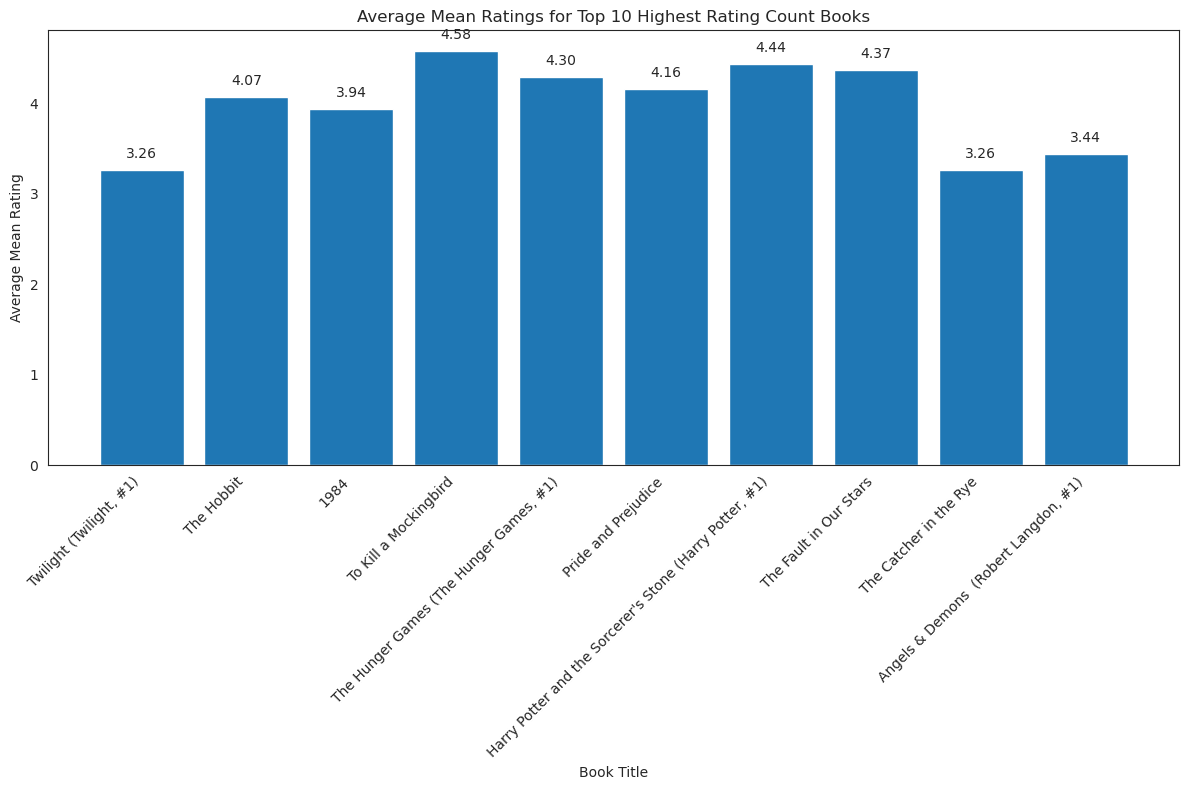

In [70]:
#Visualizations: Find the 'Average Mean Ratings for Top 10 Highest Rating Count Books'
import matplotlib.pyplot as plt
import pandas as pd

# Convert the list of Row objects to a Pandas DataFrame
avg_mean_ratings_df = pd.DataFrame([(row['title'], row['average_mean_rating']) for row in average_mean_ratings], columns=['Book Title', 'Average Mean Rating'])

# Set up the bar plot
plt.figure(figsize=(12, 8))
bar_plot = plt.bar(avg_mean_ratings_df['Book Title'], avg_mean_ratings_df['Average Mean Rating'])
plt.xlabel('Book Title')
plt.ylabel('Average Mean Rating')
plt.title('Average Mean Ratings for Top 10 Highest Rating Count Books')

# Adding graph annotations 
for i, val in enumerate(avg_mean_ratings_df['Average Mean Rating']):
    plt.text(i, val + 0.1, f'{val:.2f}', ha='center', va='bottom')

# Rotate x-axis labels 
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


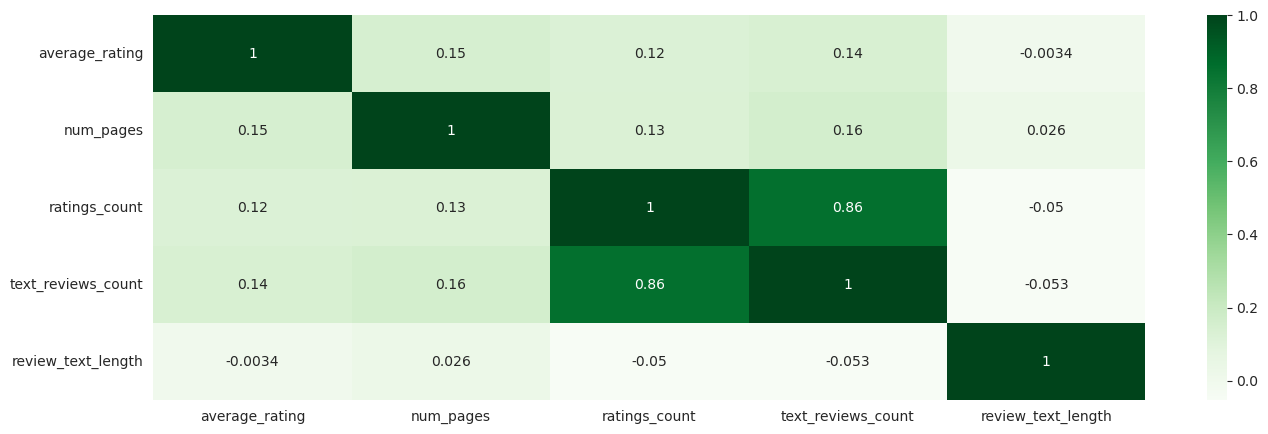

In [58]:
#Visualizations: finding the correlation Matrix
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns

# Correlation matrix using Seaborn
import seaborn as sns
# Convert the numeric values to vector columns
vector_column = "correlation_features"
# Choose the numeric (Double) columns 
numeric_columns = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'review_text_length']
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(sdf).select(vector_column)

# Create the correlation matrix, then get just the values and convert to a list
matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist() 
# Convert the correlation to a Pandas dataframe
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns, index=numeric_columns) 

heatmap_plot = plt.figure(figsize=(16,5))  
# Set the style for Seaborn plots
sns.set_style("white")

sns.heatmap(correlation_matrix_df, 
            xticklabels=correlation_matrix_df.columns.values,
            yticklabels=correlation_matrix_df.columns.values,  cmap="Greens", annot=True)
plt.savefig("correlation_matrix.png")

In [59]:
# Saving Seaborn Heatmap plot to GCS
import io
from google.cloud import storage
# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the buffer
heatmap_plot.savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket
bucket = storage_client.get_bucket('my-bucket-apb')

# Create a blob to hold the data. Give it a file name
blob = bucket.blob("correlation_matrix_plot.png")
# Upload the img_data contents to the blob
blob.upload_from_file(img_data)


In [4]:
#Creating label
from pyspark.sql.functions import when

#If rating is greater than or equal to 4, then it is 1. Otherwise it is 0
sdf = sdf.withColumn("label", when(sdf.rating >= 4, 1.0).otherwise(0.0))


In [6]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Define the input columns for the VectorAssembler
input_cols = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'review_text_length']

# Create the VectorAssembler
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')

# Create the MinMaxScaler
scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# Define your pipeline with the VectorAssembler and MinMaxScaler
text_pipeline = Pipeline(stages=[assembler, scaler])

# Fit and transform your data using the pipeline
transformed_sdf = text_pipeline.fit(sdf).transform(sdf)

transformed_sdf.select('book_id','average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'review_text_length','scaled_features').show(5, truncate=80)


+-------+--------------+---------+-------------+------------------+------------------+--------------------------------------------------------------------------------+
|book_id|average_rating|num_pages|ratings_count|text_reviews_count|review_text_length|                                                                 scaled_features|
+-------+--------------+---------+-------------+------------------+------------------+--------------------------------------------------------------------------------+
|     24|          4.05|      335|        60221|              3738|               690|[0.8100000381469727,0.009054054054054054,0.01229008778634133,0.02620491429773...|
|     24|          4.05|      335|        60221|              3738|              1030|[0.8100000381469727,0.009054054054054054,0.01229008778634133,0.02620491429773...|
|     24|          4.05|      335|        60221|              3738|               226|[0.8100000381469727,0.009054054054054054,0.01229008778634133,0.02620491429

In [7]:
# Set display options to show more decimal places for floats
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.truncate", 1000)  

# Display the scaled_features column 
transformed_sdf.select('scaled_features').show(5, truncate=False)

+-------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                        |
+-------------------------------------------------------------------------------------------------------+
|[0.8100000381469727,0.009054054054054054,0.01229008778634133,0.026204914297732133,0.034596871239470514]|
|[0.8100000381469727,0.009054054054054054,0.01229008778634133,0.026204914297732133,0.051644604893702366]|
|[0.8100000381469727,0.009054054054054054,0.01229008778634133,0.026204914297732133,0.011331728840754111]|
|[0.8100000381469727,0.009054054054054054,0.01229008778634133,0.026204914297732133,0.001002807862013638]|
|[0.8100000381469727,0.009054054054054054,0.01229008778634133,0.026204914297732133,0.02812876052948255] |
+-------------------------------------------------------------------------------------------------------+
only showing top 5 rows



In [8]:
#Create pipeline for review_text column

from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF


regexTokenizer = RegexTokenizer(inputCol="review_text", outputCol="words", pattern="\\w+", gaps=False)

hashingTF = HashingTF(numFeatures=4096, inputCol="words", outputCol="word_features")

idf = IDF(inputCol='word_features', outputCol="features2", minDocFreq=1)

words_pipeline = Pipeline(stages=[regexTokenizer, hashingTF, idf])

pipeline_model = words_pipeline.fit(transformed_sdf)
transformed_sdf1 = pipeline_model.transform(transformed_sdf)

# Show the selected columns with truncation for better display
transformed_sdf1.select("user_id", "features2").show(5, truncate=80)


+--------------------------------+--------------------------------------------------------------------------------+
|                         user_id|                                                                       features2|
+--------------------------------+--------------------------------------------------------------------------------+
|f94a43aa524f516bb4b95050b3e7091d|(4096,[46,97,280,345,358,436,467,469,509,611,666,693,697,778,814,849,858,868,...|
|35c1a8330df4f54e11252ff691bd6124|(4096,[46,123,129,226,280,345,397,404,413,425,433,444,509,611,637,655,666,818...|
|ae17b0cd259c0fcf102f246e926d8761|(4096,[280,282,406,459,611,917,942,1343,1489,1495,1509,1999,2284,2408,2435,24...|
|aa3a874c991cd9fecdd68e4c9938ba0c|(4096,[1080,2170,3511,3536],[2.9891998964935995,3.8693610010972033,4.37336862...|
|746088aad5aa40cd0f079bbdf4d2d949|(4096,[87,122,129,280,322,369,460,485,611,697,700,726,731,849,907,917,941,114...|
+--------------------------------+--------------------------------------

In [9]:
from pyspark.ml.feature import VectorAssembler

# Assuming transformed_sdf1 contains the output columns 'scaled_features' and 'features2'
transformed_sdf1 = transformed_sdf1.withColumnRenamed('features2', 'features2_renamed')

# Create the VectorAssembler with the renamed columns
assembler = VectorAssembler(inputCols=['scaled_features', 'features2_renamed'], outputCol='combined_features')

transformed_sdf1 = assembler.transform(transformed_sdf1)


In [10]:
transformed_sdf1.printSchema()

root
 |-- book_id: integer (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- author_id: integer (nullable = true)
 |    |    |-- role: string (nullable = true)
 |-- average_rating: float (nullable = true)
 |-- description: string (nullable = true)
 |-- format: string (nullable = true)
 |-- num_pages: integer (nullable = true)
 |-- popular_shelves: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- count: integer (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- ratings_count: integer (nullable = true)
 |-- text_reviews_count: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- publication_date: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- review_text: string (nullable = true)
 |-- n_votes: integer (nullable = true)
 |-- n_comments: integer (nullable = true)
 |-- date_added_formatted: st

In [11]:
spark.conf.set("spark.sql.debug.maxToStringFields", "80")

#show first 5 rows with label and features 
transformed_sdf1.select('book_id','label','average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'review_text_length','scaled_features','combined_features').show(5, truncate=60)


+-------+-----+--------------+---------+-------------+------------------+------------------+------------------------------------------------------------+------------------------------------------------------------+
|book_id|label|average_rating|num_pages|ratings_count|text_reviews_count|review_text_length|                                             scaled_features|                                           combined_features|
+-------+-----+--------------+---------+-------------+------------------+------------------+------------------------------------------------------------+------------------------------------------------------------+
|     24|  0.0|          4.05|      335|        60221|              3738|               690|[0.8100000381469727,0.009054054054054054,0.01229008778634...|(4101,[0,1,2,3,4,51,102,285,350,363,441,472,474,514,616,6...|
|     24|  0.0|          4.05|      335|        60221|              3738|              1030|[0.8100000381469727,0.009054054054054054,0.01229

In [12]:
sc.setLogLevel("ERROR")

from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

trainingData, testData = transformed_sdf1.randomSplit([0.70, 0.3], seed=42)

# Check if 'combined_features' is in the schema
if 'combined_features' in transformed_sdf1.columns:
    print("'combined_features' column exists in the schema.")
else:
    print("'combined_features' column does not exist in the schema.")

# Assuming 'combined_features' exists, fit Logistic Regression
if 'combined_features' in transformed_sdf1.columns:
    # Create Logistic Regression with 'combined_features' as featuresCol
    lr = LogisticRegression(featuresCol='combined_features', labelCol='label')
    
    # Fit the model to the training data
    model = lr.fit(trainingData)
    
    # Show model coefficients and intercept
    print("Coefficients: ", model.coefficients)
    print("Intercept: ", model.intercept)
else:
    print("Cannot fit Logistic Regression. 'combined_features' column not found.")


'combined_features' column exists in the schema.


Coefficients:  [8.707134106534669,-7.446381119593436,-0.01023505418031109,0.11435225428052972,0.4473388696488691,0.005261531838729221,-0.017328276501561025,-0.00905900096726195,-0.005127524534670055,-0.005556695895395842,-0.006309292361149107,-0.028029130886867093,-0.003065795740380778,-0.07573768067983291,-0.0028623788826459256,-0.0067559492105635915,0.016606905504053644,0.004538596052950018,0.01579024939260246,-0.01187650918592819,0.01505558066398512,0.006559243528584779,-0.005957060334946107,-0.1501379345091635,0.022617968250826556,-0.03285942441179578,0.00797909774093869,-0.006390515328930141,0.008209696466585828,0.021426893668265706,-0.051919474382432905,0.0014881242665010829,0.023197634333715033,-0.011831045030237478,0.0016938040149478797,-0.01890390244296702,0.06003971433773171,0.012392267537605126,0.006986524249388002,0.024831065224974126,-0.0035080775487759414,0.004916383567049415,0.000998269308609061,-0.016602724141021707,-0.0016227363212817588,0.006726212672912021,0.00924046

In [13]:
# Test the model on the testData
test_results = model.transform(testData)


test_results.select('title','user_id','rating','label','rawPrediction', 'prediction', 'probability').show(truncate=60)


+------------------------------------------------------+--------------------------------+------+-----+--------------------------------------------+----------+-----------------------------------------+
|                                                 title|                         user_id|rating|label|                               rawPrediction|prediction|                              probability|
+------------------------------------------------------+--------------------------------+------+-----+--------------------------------------------+----------+-----------------------------------------+
|Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)|65b05f124de8e181e148833b2ebb1f3b|     3|  0.0|      [2.072517746686609,-2.072517746686609]|       0.0| [0.8882032137839949,0.11179678621600508]|
|                                In a Sunburned Country|25bbaa66224c67e637e4d908dcf40ae4|     5|  1.0|    [-1.8910428928935064,1.8910428928935064]|       1.0|  [0.1311256051823336,0.86887439481766

In [14]:
test_results.groupby('label').pivot('prediction').count().sort('label').show()

+-----+-----+------+
|label|  0.0|   1.0|
+-----+-----+------+
|  0.0|36574| 32828|
|  1.0|13918|129431|
+-----+-----+------+



In [15]:
# Save the confusion matrix
cm = test_results.groupby('label').pivot('prediction').count().fillna(0).collect()
def calculate_recall_precision(cm):
    tn = cm[0][1] # True Negative
    fp = cm[0][2] # False Positive
    fn = cm[1][1] # False Negative
    tp = cm[1][2] # True Positive
    precision = tp / ( tp + fp )
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score
print( calculate_recall_precision(cm) )

(0.21972164643174416, 0.20231851545985122, 0.4730123051208899, 0.2834141266764798)


In [16]:
# Create a grid to hold hyperparameters 
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
grid = grid.addGrid(lr.elasticNetParam, [0, 0.5, 1])

# Build the parameter grid
grid = grid.build()

# How many models to be tested
print('Number of models to be tested: ', len(grid))

# Create a BinaryClassificationEvaluator to evaluate how well the model works
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator= lr, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=3)

# Train the models
all_models  = cv.fit(trainingData)

print("Average Metrics for Each model: ", all_models.avgMetrics)

Number of models to be tested:  18


Average Metrics for Each model:  [0.8275562825444734, 0.8275576610002576, 0.8275555676182481, 0.825560869967808, 0.6664968889290339, 0.5, 0.8233794463796379, 0.5, 0.5, 0.8217012819185433, 0.5, 0.5, 0.8203310042605243, 0.5, 0.5, 0.8191787948369061, 0.5, 0.5]


In [17]:
# Get the best model from all of the models trained
bestModel = all_models.bestModel
print("Area under ROC curve:", bestModel.summary.areaUnderROC)

Area under ROC curve: 0.838164987882569


In [18]:
# Use the model 'bestModel' to predict the test set
test_results = bestModel.transform(testData)

In [19]:
# Show the results
test_results.select('user_id','title','rating', 'probability','prediction','label').show(truncate=True)

# Evaluate the predictions. Area Under ROC curve
print(evaluator.evaluate(test_results))

+--------------------+--------------------+------+--------------------+----------+-----+
|             user_id|               title|rating|         probability|prediction|label|
+--------------------+--------------------+------+--------------------+----------+-----+
|65b05f124de8e181e...|Harry Potter Boxe...|     3|[0.88820320969858...|       0.0|  0.0|
|25bbaa66224c67e63...|In a Sunburned Co...|     5|[0.13112560918820...|       1.0|  1.0|
|35c1a8330df4f54e1...|In a Sunburned Co...|     2|[0.92188663589700...|       0.0|  0.0|
|3a45cadc9e0fc7c26...|In a Sunburned Co...|     5|[0.14294026955910...|       1.0|  1.0|
|4b8b29a0551d0b108...|In a Sunburned Co...|     2|[0.62412886175154...|       0.0|  0.0|
|52a2fbad315b08429...|In a Sunburned Co...|     3|[0.29938775750103...|       1.0|  0.0|
|70c090f200c0e2420...|In a Sunburned Co...|     4|[0.19331699645458...|       1.0|  1.0|
|aa3a874c991cd9fec...|In a Sunburned Co...|     0|[0.32522542382434...|       1.0|  0.0|
|bd5ca61c182ccb40e...

0.8304826011577369


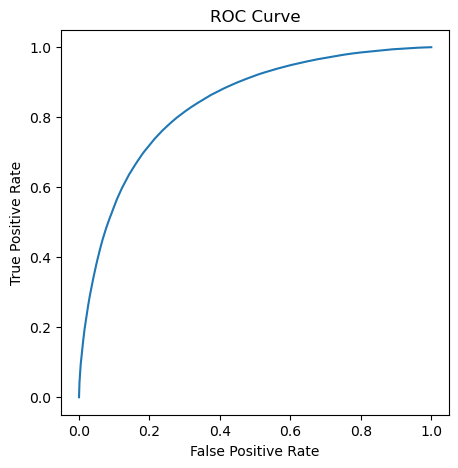

In [20]:
#Display best model ROC Curve graph
mymodel = bestModel

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(mymodel.summary.roc.select('FPR').collect(),
         mymodel.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.savefig("roc1.png")
plt.show()

In [21]:
# Gather the metrics and parameters of the model with the best average metrics
hyperparams = all_models.getEstimatorParamMaps()[np.argmax(all_models.avgMetrics)]

# Print out the list of hyperparameters for the best model
for i in range(len(hyperparams.items())):
 print([x for x in hyperparams.items()][i])

# Print out the list of hyperparameters for the best model
for param, value in hyperparams.items():
    print(f"{param.name}: {value}")

(Param(parent='LogisticRegression_f3b680680378', name='regParam', doc='regularization parameter (>= 0).'), 0.0)
(Param(parent='LogisticRegression_f3b680680378', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'), 0.5)
regParam: 0.0
elasticNetParam: 0.5


In [22]:
# Extract the coefficients on each of the variables
coeff = mymodel.coefficients.toArray().tolist()

# Loop through the numeric features to extract the original column names. Store in the var_index dictionary
var_index = dict()
for variable in test_results.schema["combined_features"].metadata["ml_attr"]["attrs"]["numeric"]:
    idx = variable['idx']
    name = variable['name']
    var_index[idx] = name  # Add the name to the dictionary

# Loop through all of the variables found and print out the associated coefficients
for i in range(len(var_index)):
    print(f"Coefficient {i}: {var_index[i]} - {coeff[i]}")


Coefficient 0: scaled_features_0 - 8.707134035490798
Coefficient 1: scaled_features_1 - -7.446380827906977
Coefficient 2: scaled_features_2 - -0.01023509581161212
Coefficient 3: scaled_features_3 - 0.1143522396460918
Coefficient 4: scaled_features_4 - 0.4473400016291513
Coefficient 5: features2_renamed_0 - 0.005261530733544184
Coefficient 6: features2_renamed_1 - -0.017328276716964044
Coefficient 7: features2_renamed_2 - -0.009058999888771914
Coefficient 8: features2_renamed_3 - -0.0051275242736164425
Coefficient 9: features2_renamed_4 - -0.0055566951752247665
Coefficient 10: features2_renamed_5 - -0.006309290152772925
Coefficient 11: features2_renamed_6 - -0.028029132266228336
Coefficient 12: features2_renamed_7 - -0.003065795311759334
Coefficient 13: features2_renamed_8 - -0.07573767973753769
Coefficient 14: features2_renamed_9 - -0.002862379931078315
Coefficient 15: features2_renamed_10 - -0.006755946001081092
Coefficient 16: features2_renamed_11 - 0.01660690547193473
Coefficient 17